# Análise Exploratória de Dados - Detecção de Fraudes nas Entregas do Walmart

Este notebook tem como objetivo explorar os dados coletados pelo Walmart na região Central da Flórida e identificar padrões que possam estar associados a fraudes durante o processo de entrega.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import re
from datetime import datetime
from scipy import stats

plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


##  Data Load

In [31]:

def load_data():
    """
    Carrega os dados das tabelas salvas no banco de dados SQLite
    """
    db_path = r'C:\Users\louis\datatech\Database\walmart_fraudes.db'
    conn = sqlite3.connect(db_path)

    # Lendo os DataFrames diretamente do banco
    orders_df = pd.read_sql("SELECT * FROM orders", conn)
    drivers_df = pd.read_sql("SELECT * FROM drivers", conn)
    customers_df = pd.read_sql("SELECT * FROM customers", conn)
    missing_items_df = pd.read_sql("SELECT * FROM missing_items", conn)
    products_df = pd.read_sql("SELECT * FROM products", conn)

    # Pré-processamentos básicos
    orders_df['order_amount'] = orders_df['order_amount'].astype(float)
    orders_df['date'] = pd.to_datetime(orders_df['date'])
    orders_df['delivery_hour_only'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[0]))
    orders_df['delivery_minute'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[1]))
    orders_df['delivery_second'] = orders_df['delivery_hour'].apply(lambda x: int(x.split(':')[2]))

    def categorize_time(hour):
        if 5 <= hour < 12:
            return 'Manhã'
        elif 12 <= hour < 18:
            return 'Tarde'
        else:
            return 'Noite'

    orders_df['period_of_day'] = orders_df['delivery_hour_only'].apply(categorize_time)

    return conn, orders_df, drivers_df, customers_df, missing_items_df, products_df


## 📊 Análise Exploratória (EDA)

In [32]:
def exploratory_data_analysis(conn, orders_df, drivers_df, customers_df, missing_items_df, products_df):
    print("Realizando análise exploratória dos dados...")

    # 1. Análise descritiva básica
    print("\n1. Estatísticas descritivas dos pedidos:")
    print(orders_df[['order_amount', 'items_delivered', 'items_missing']].describe())

    # 2. Distribuição da quantidade de itens faltantes
    plt.figure(figsize=(10, 6))
    sns.countplot(x='items_missing', data=orders_df)
    plt.title('Distribuição da Quantidade de Itens Faltantes')
    plt.xlabel('Número de Itens Faltantes')
    plt.ylabel('Contagem')
    plt.show()

    # 3. Proporção de itens faltantes
    orders_df['total_items'] = orders_df['items_delivered'] + orders_df['items_missing']
    orders_df['missing_ratio'] = orders_df['items_missing'] / orders_df['total_items']

    print("\n2. Estatísticas da proporção de itens faltantes:")
    print(orders_df['missing_ratio'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(orders_df['missing_ratio'], bins=20, kde=True)
    plt.title('Distribuição da Proporção de Itens Faltantes')
    plt.xlabel('Proporção de Itens Faltantes')
    plt.ylabel('Frequência')
    plt.show()

    # 4. Itens faltantes por região
    region_stats = orders_df.groupby('region').agg({
        'order_id': 'count',
        'items_missing': 'sum',
        'total_items': 'sum'
    }).reset_index()

    region_stats['missing_ratio'] = region_stats['items_missing'] / region_stats['total_items']
    region_stats = region_stats.sort_values('missing_ratio', ascending=False)

    print("\n3. Taxa de itens faltantes por região:")
    print(region_stats)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='region', y='missing_ratio', data=region_stats)
    plt.title('Proporção de Itens Faltantes por Região')
    plt.xlabel('Região')
    plt.ylabel('Proporção de Itens Faltantes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5. Por período do dia
    period_stats = orders_df.groupby('period_of_day').agg({
        'order_id': 'count',
        'items_missing': 'sum',
        'total_items': 'sum'
    }).reset_index()

    period_stats['missing_ratio'] = period_stats['items_missing'] / period_stats['total_items']

    print("\n4. Taxa de itens faltantes por período do dia:")
    print(period_stats)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='period_of_day', y='missing_ratio', data=period_stats)
    plt.title('Proporção de Itens Faltantes por Período do Dia')
    plt.xlabel('Período do Dia')
    plt.ylabel('Proporção de Itens Faltantes')
    plt.show()

    # 6. Análise por motorista
    driver_stats_query = """
    SELECT 
        d.driver_id,
        d.driver_name,
        d.age,
        d.Trips,
        COUNT(o.order_id) AS orders_delivered,
        SUM(o.items_missing) AS total_missing_items,
        SUM(o.items_delivered + o.items_missing) AS total_items,
        CAST(SUM(o.items_missing) AS FLOAT) / CAST(SUM(o.items_delivered + o.items_missing) AS FLOAT) AS missing_ratio
    FROM 
        drivers d
    JOIN 
        orders o ON d.driver_id = o.driver_id
    GROUP BY 
        d.driver_id
    ORDER BY 
        missing_ratio DESC
    """
    driver_stats = pd.read_sql(driver_stats_query, conn)

    print("\n5. Top 10 motoristas com maior taxa de itens faltantes:")
    print(driver_stats.head(10))

    # 7. Por faixa etária do motorista
    driver_stats['age_group'] = pd.cut(driver_stats['age'], bins=[17, 25, 35, 45, 55, 65, 100],
                                       labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

    age_group_stats = driver_stats.groupby('age_group').agg({
        'driver_id': 'count',
        'total_missing_items': 'sum',
        'total_items': 'sum'
    }).reset_index()

    age_group_stats['missing_ratio'] = age_group_stats['total_missing_items'] / age_group_stats['total_items']

    print("\n6. Taxa de itens faltantes por faixa etária do motorista:")
    print(age_group_stats)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='age_group', y='missing_ratio', data=age_group_stats)
    plt.title('Proporção de Itens Faltantes por Faixa Etária do Motorista')
    plt.xlabel('Faixa Etária')
    plt.ylabel('Proporção de Itens Faltantes')
    plt.show()

    # 8. Por faixa etária do cliente
    customer_stats_query = """
    SELECT 
        c.customer_id,
        c.customer_name,
        c.customer_age,
        COUNT(o.order_id) AS orders_placed,
        SUM(o.items_missing) AS total_missing_items,
        SUM(o.items_delivered + o.items_missing) AS total_items,
        CAST(SUM(o.items_missing) AS FLOAT) / CAST(SUM(o.items_delivered + o.items_missing) AS FLOAT) AS missing_ratio
    FROM 
        customers c
    JOIN 
        orders o ON c.customer_id = o.customer_id
    GROUP BY 
        c.customer_id
    """
    customer_stats = pd.read_sql(customer_stats_query, conn)

    customer_stats['age_group'] = pd.cut(customer_stats['customer_age'], bins=[17, 25, 35, 45, 55, 65, 100],
                                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

    customer_age_group_stats = customer_stats.groupby('age_group').agg({
        'customer_id': 'count',
        'total_missing_items': 'sum',
        'total_items': 'sum'
    }).reset_index()

    customer_age_group_stats['missing_ratio'] = customer_age_group_stats['total_missing_items'] / customer_age_group_stats['total_items']

    print("\n7. Taxa de itens faltantes por faixa etária do cliente:")
    print(customer_age_group_stats)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='age_group', y='missing_ratio', data=customer_age_group_stats)
    plt.title('Proporção de Itens Faltantes por Faixa Etária do Cliente')
    plt.xlabel('Faixa Etária')
    plt.ylabel('Proporção de Itens Faltantes')
    plt.show()

    # 9. Categorias de produtos mais reportadas como faltantes
    missing_by_category = None
    missing_products_query = """
    WITH missing_products AS (
        SELECT order_id, product_id_1 AS product_id FROM missing_items WHERE product_id_1 IS NOT NULL
        UNION ALL
        SELECT order_id, product_id_2 AS product_id FROM missing_items WHERE product_id_2 IS NOT NULL
        UNION ALL
        SELECT order_id, product_id_3 AS product_id FROM missing_items WHERE product_id_3 IS NOT NULL
    )
    SELECT 
        p.category,
        COUNT(*) AS count_missing
    FROM 
        missing_products mp
    JOIN 
        products p ON mp.product_id = p.product_id
    GROUP BY 
        p.category
    ORDER BY 
        count_missing DESC
    """
    try:
        missing_by_category = pd.read_sql(missing_products_query, conn)
        print("\n8. Categorias de produtos mais frequentemente reportados como faltantes:")
        print(missing_by_category.head(10))

        plt.figure(figsize=(12, 6))
        sns.barplot(x='category', y='count_missing', data=missing_by_category)
        plt.title('Número de Produtos Faltantes por Categoria')
        plt.xlabel('Categoria')
        plt.ylabel('Contagem')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erro ao analisar categorias de produtos: {e}")

    # 10. Valor do pedido vs. itens faltantes
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='order_amount', y='items_missing', data=orders_df)
    plt.title('Relação entre Valor do Pedido e Número de Itens Faltantes')
    plt.xlabel('Valor do Pedido ($)')
    plt.ylabel('Número de Itens Faltantes')
    plt.show()

    corr = orders_df['order_amount'].corr(orders_df['items_missing'])
    print(f"\n9. Correlação entre valor do pedido e itens faltantes: {corr:.4f}")

    # 11. Tendência mensal
    monthly_stats = orders_df.groupby(orders_df['date'].dt.to_period('M')).agg({
        'order_id': 'count',
        'items_missing': 'sum',
        'total_items': 'sum'
    }).reset_index()

    monthly_stats['date'] = monthly_stats['date'].astype(str)
    monthly_stats['missing_ratio'] = monthly_stats['items_missing'] / monthly_stats['total_items']

    print("\n10. Tendência mensal da taxa de itens faltantes:")
    print(monthly_stats)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='missing_ratio', data=monthly_stats, marker='o')
    plt.title('Tendência Mensal da Proporção de Itens Faltantes')
    plt.xlabel('Mês')
    plt.ylabel('Proporção de Itens Faltantes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return driver_stats, customer_stats, missing_by_category, monthly_stats


In [33]:
def detect_fraud_patterns(conn, driver_stats, customer_stats):
    print("\nDetectando padrões de fraude...")
    
    # 1. Motoristas com alta taxa de itens faltantes (outliers)
    # Calculando limites para outliers usando o método do IQR (Interquartile Range)
    Q1 = driver_stats['missing_ratio'].quantile(0.25)
    Q3 = driver_stats['missing_ratio'].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    
    suspicious_drivers = driver_stats[driver_stats['missing_ratio'] > upper_bound].copy()
    suspicious_drivers = suspicious_drivers.sort_values('missing_ratio', ascending=False)
    
    print("\n1. Motoristas suspeitos (alta taxa de itens faltantes):")
    print(suspicious_drivers[['driver_id', 'driver_name', 'age', 'orders_delivered', 'total_missing_items', 'missing_ratio']])
    
    # 2. Clientes com alta taxa de reclamações (outliers)
    Q1_customer = customer_stats['missing_ratio'].quantile(0.25)
    Q3_customer = customer_stats['missing_ratio'].quantile(0.75)
    IQR_customer = Q3_customer - Q1_customer
    
    upper_bound_customer = Q3_customer + 1.5 * IQR_customer
    
    suspicious_customers = customer_stats[customer_stats['missing_ratio'] > upper_bound_customer].copy()
    suspicious_customers = suspicious_customers.sort_values('missing_ratio', ascending=False)
    
    print("\n2. Clientes suspeitos (alta taxa de reclamações):")
    print(suspicious_customers[['customer_id', 'customer_name', 'customer_age', 'orders_placed', 'total_missing_items', 'missing_ratio']])
    
    # 3. Análise da hora do dia e região para motoristas suspeitos
    suspicious_drivers_query = f"""
    SELECT 
        o.delivery_hour_only,
        o.period_of_day,
        o.region,
        COUNT(*) as order_count,
        SUM(o.items_missing) as total_missing
    FROM 
        orders o
    WHERE 
        o.driver_id IN ({','.join([f"'{d}'" for d in suspicious_drivers['driver_id']])})
    GROUP BY 
        o.delivery_hour_only, o.period_of_day, o.region
    ORDER BY 
        total_missing DESC
    """
    
    suspicious_patterns = pd.read_sql(suspicious_drivers_query, conn)
    
    print("\n3. Padrões de entrega de motoristas suspeitos:")
    print(suspicious_patterns.head(10))
    
    # 4. Análise de produtos mais frequentemente reportados como faltantes por motoristas suspeitos
    suspicious_products_query = f"""
    WITH missing_products AS (
        SELECT mi.order_id, mi.product_id_1 AS product_id FROM missing_items mi
        JOIN orders o ON mi.order_id = o.order_id
        WHERE o.driver_id IN ({','.join([f"'{d}'" for d in suspicious_drivers['driver_id']])})
        AND mi.product_id_1 IS NOT NULL
        
        UNION ALL
        
        SELECT mi.order_id, mi.product_id_2 AS product_id FROM missing_items mi
        JOIN orders o ON mi.order_id = o.order_id
        WHERE o.driver_id IN ({','.join([f"'{d}'" for d in suspicious_drivers['driver_id']])})
        AND mi.product_id_2 IS NOT NULL
        
        UNION ALL
        
        SELECT mi.order_id, mi.product_id_3 AS product_id FROM missing_items mi
        JOIN orders o ON mi.order_id = o.order_id
        WHERE o.driver_id IN ({','.join([f"'{d}'" for d in suspicious_drivers['driver_id']])})
        AND mi.product_id_3 IS NOT NULL
    )
    SELECT 
        p.product_id,
        p.product_name,
        p.category,
        p.price,
        COUNT(*) AS count_missing
    FROM 
        missing_products mp
    JOIN 
        products p ON mp.product_id = p.product_id
    GROUP BY 
        p.product_id
    ORDER BY 
        count_missing DESC, p.price DESC
    """
    
    try:
        suspicious_products = pd.read_sql(suspicious_products_query, conn)
        
        print("\n4. Produtos mais frequentemente relatados como faltantes por motoristas suspeitos:")
        print(suspicious_products.head(10))
    except Exception as e:
        print(f"Erro ao analisar produtos faltantes de motoristas suspeitos: {e}")
    
    return suspicious_drivers, suspicious_customers, suspicious_patterns


Realizando análise exploratória dos dados...

1. Estatísticas descritivas dos pedidos:
       order_amount  items_delivered  items_missing
count  10000.000000     10000.000000    10000.00000
mean     283.302238         9.969400        0.16570
std      181.681638         5.459693        0.41432
min       20.080000         1.000000        0.00000
25%      147.565000         5.000000        0.00000
50%      270.535000        10.000000        0.00000
75%      393.072500        15.000000        0.00000
max     1386.000000        19.000000        3.00000


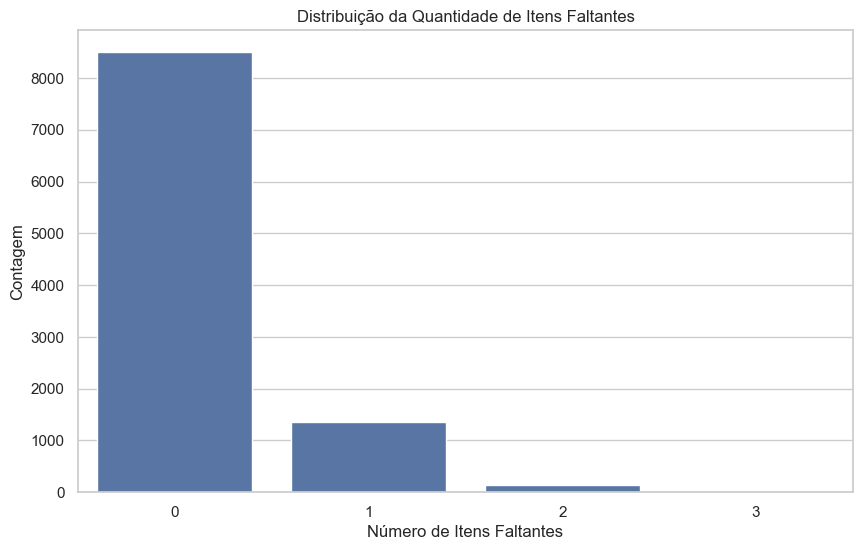


2. Estatísticas da proporção de itens faltantes:
count    10000.000000
mean         0.022132
std          0.070400
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.666667
Name: missing_ratio, dtype: float64


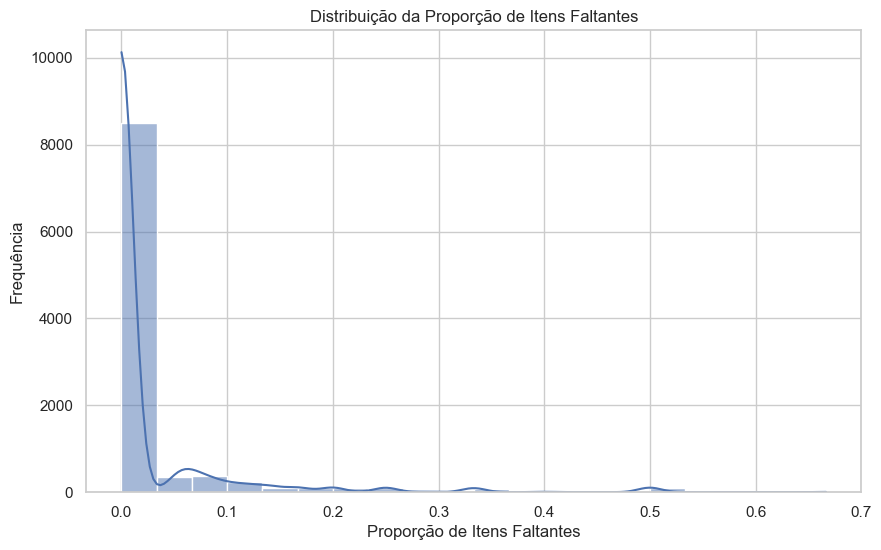


3. Taxa de itens faltantes por região:
              region  order_id  items_missing  total_items  missing_ratio
0  Altamonte Springs      1426            253        14387       0.017585
1             Apopka      1422            249        14402       0.017289
2           Clermont      1384            243        14129       0.017199
4            Orlando      1401            233        14219       0.016387
6        Winter Park      1485            235        15025       0.015641
5            Sanford      1461            225        14625       0.015385
3          Kissimmee      1421            219        14564       0.015037


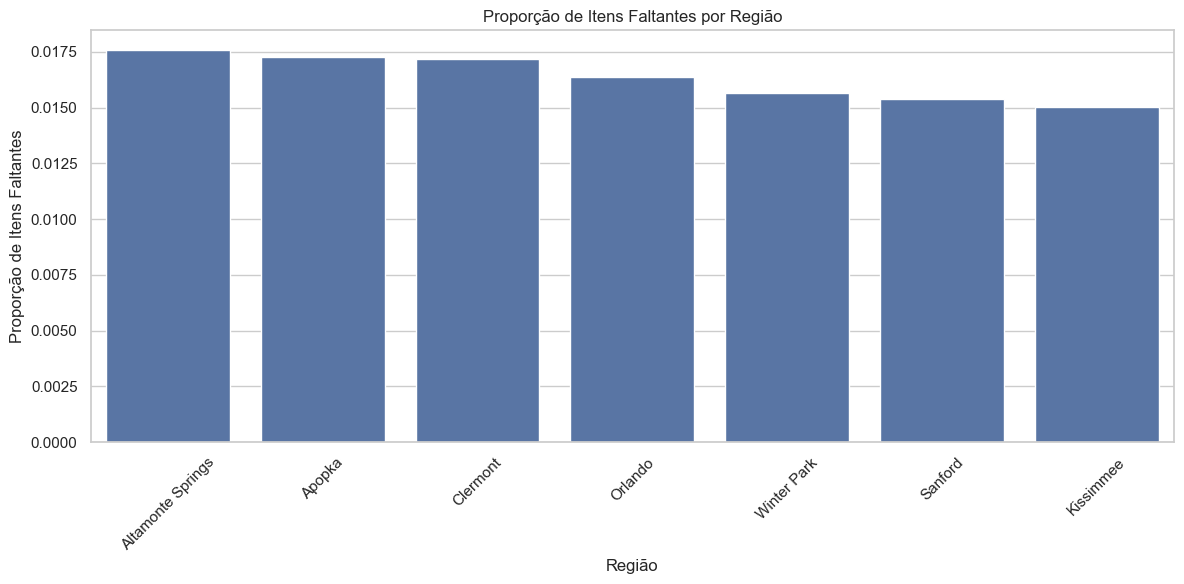


4. Taxa de itens faltantes por período do dia:
  period_of_day  order_id  items_missing  total_items  missing_ratio
0         Manhã      2926            517        29829       0.017332
1         Noite      4548            736        45950       0.016017
2         Tarde      2526            404        25572       0.015799


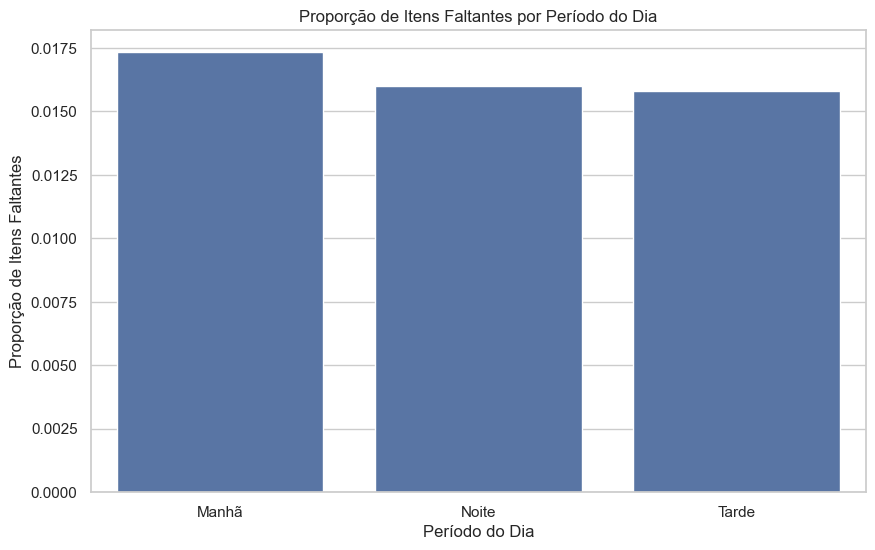


5. Top 10 motoristas com maior taxa de itens faltantes:
   driver_id       driver_name  age  Trips  orders_delivered  \
0  WDID10322     Dana Ferguson   22     40                11   
1  WDID10222       Daniel Hall   20     40                11   
2  WDID09884     James Winters   18     22                11   
3  WDID09875  Stephen Randolph   18     64                11   
4  WDID10447    Patricia Vance   18     40                11   
5  WDID10077      Brent Werner   19     15                11   
6  WDID10079    Brittany Kelly   19     70                11   
7  WDID09882      Angela Young   18     75                11   
8  WDID09881    Tracey Watkins   18     26                11   
9  WDID10421     Jesse Solomon   26     29                11   

   total_missing_items  total_items  missing_ratio  
0                    5           67       0.074627  
1                    5           71       0.070423  
2                    6           92       0.065217  
3                    6    

C:\Users\louis\AppData\Local\Temp\ipykernel_4064\1111480375.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = driver_stats.groupby('age_group').agg({


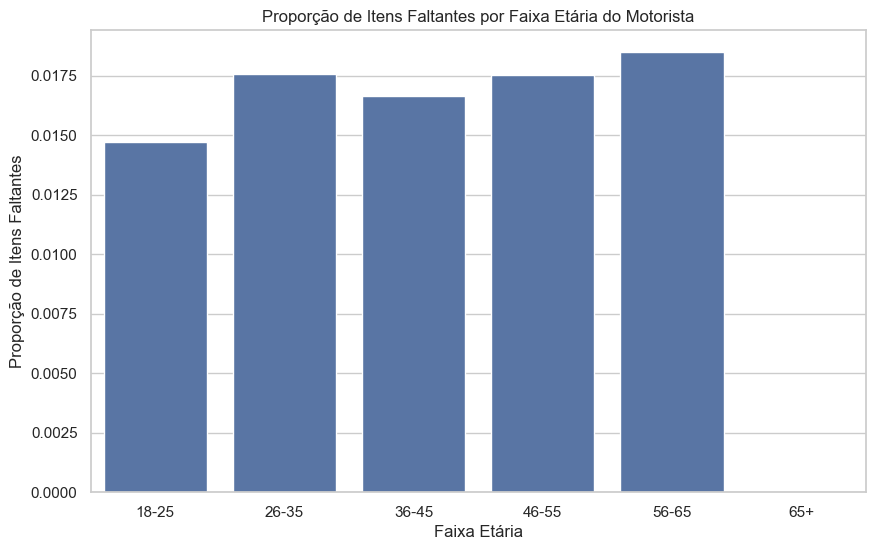


7. Taxa de itens faltantes por faixa etária do cliente:
  age_group  customer_id  total_missing_items  total_items  missing_ratio
0     18-25          134                  179        11191       0.015995
1     26-35          165                  229        13713       0.016699
2     36-45          156                  217        12467       0.017406
3     46-55          169                  195        13823       0.014107
4     56-65          187                  251        14739       0.017030
5       65+          428                  586        35418       0.016545


C:\Users\louis\AppData\Local\Temp\ipykernel_4064\1111480375.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_age_group_stats = customer_stats.groupby('age_group').agg({


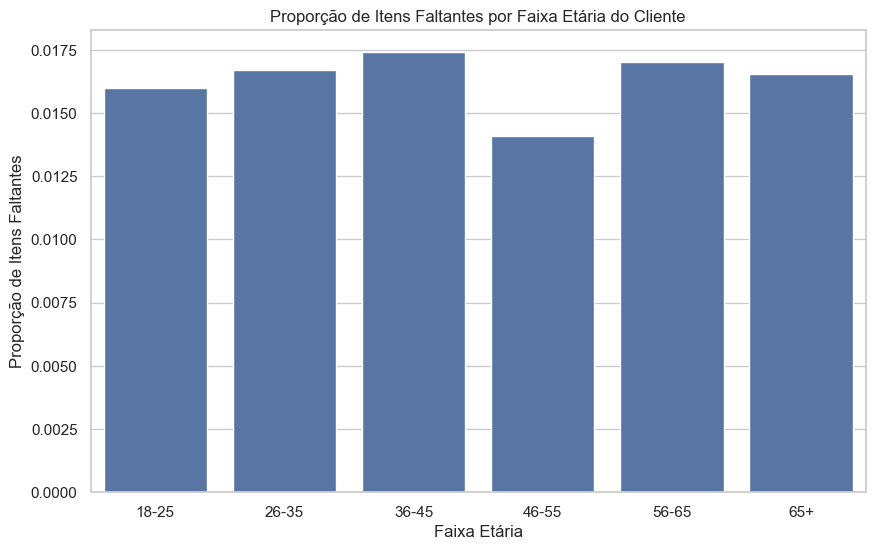


8. Categorias de produtos mais frequentemente reportados como faltantes:
      category  count_missing
0  Supermarket           1393
1  Electronics            269


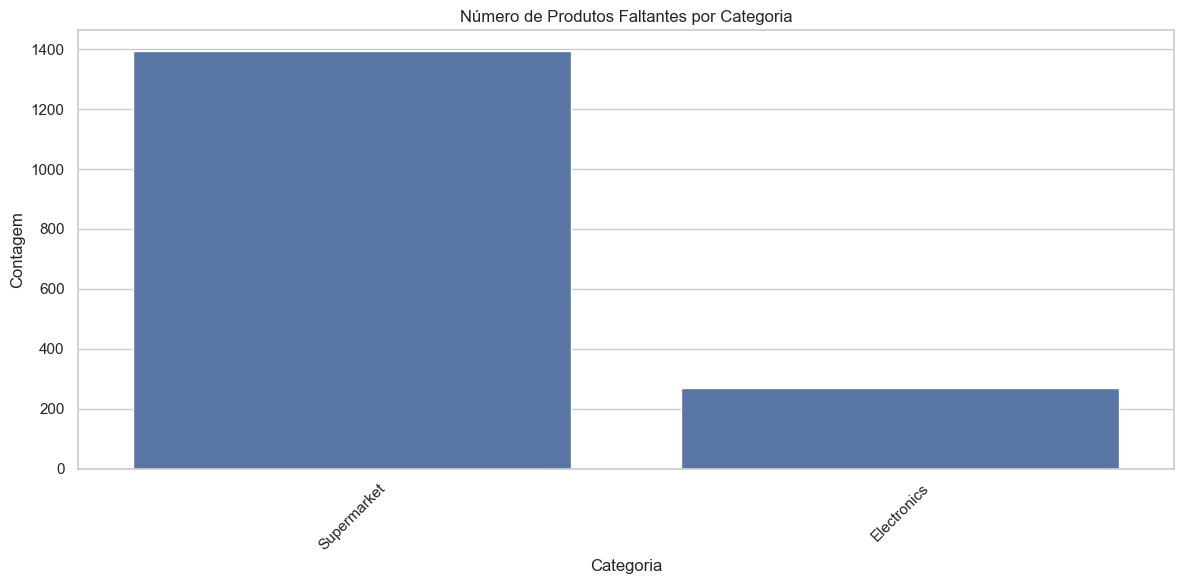

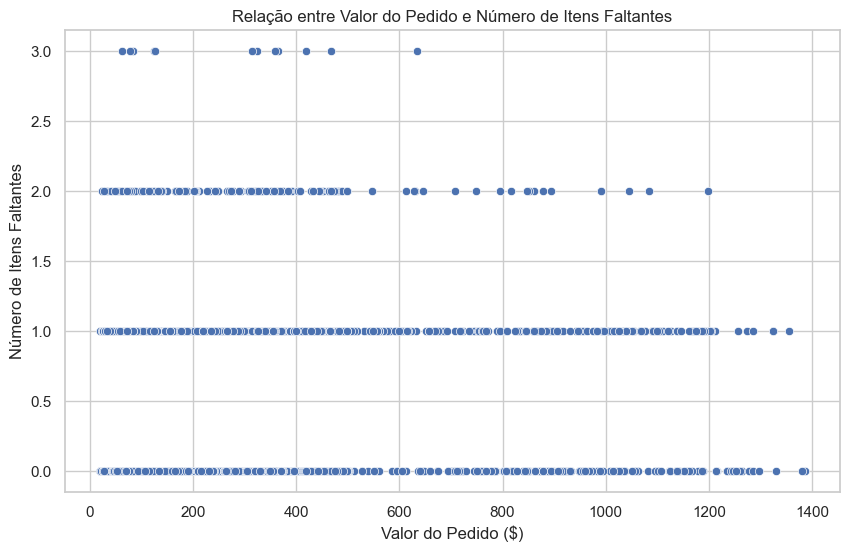


9. Correlação entre valor do pedido e itens faltantes: 0.1317

10. Tendência mensal da taxa de itens faltantes:
       date  order_id  items_missing  total_items  missing_ratio
0   2023-01       843            139         8264       0.016820
1   2023-02       745            111         7818       0.014198
2   2023-03       850            152         8675       0.017522
3   2023-04       789            133         7593       0.017516
4   2023-05       830            153         8520       0.017958
5   2023-06       823            127         8318       0.015268
6   2023-07       891            155         9408       0.016475
7   2023-08       871            157         8592       0.018273
8   2023-09       826            127         8369       0.015175
9   2023-10       866            131         8647       0.015150
10  2023-11       808            146         8339       0.017508
11  2023-12       858            126         8808       0.014305


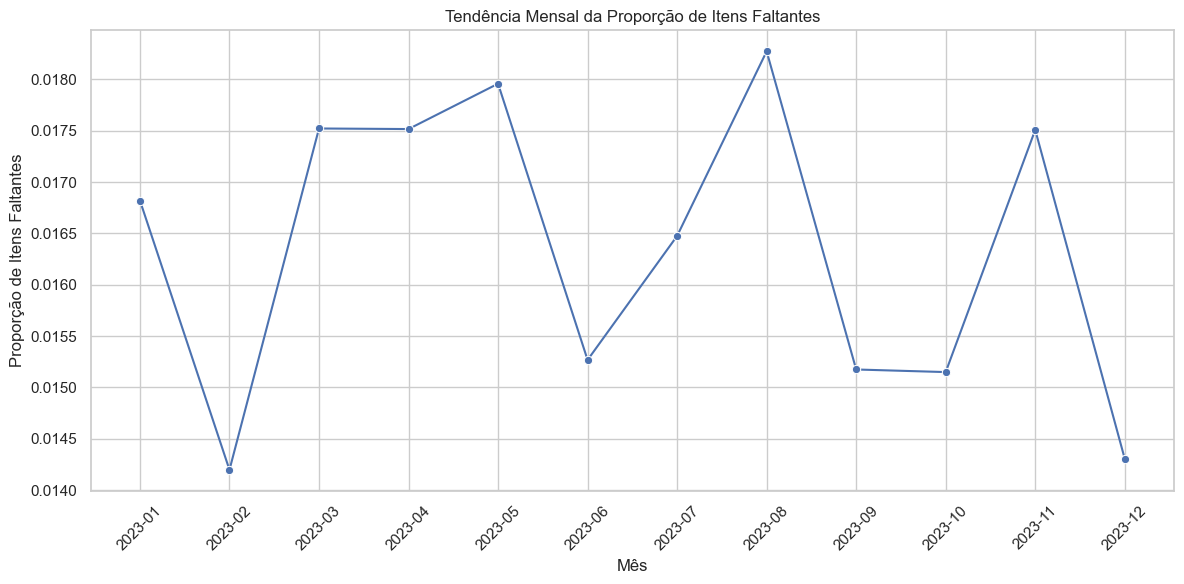


Detectando padrões de fraude...

1. Motoristas suspeitos (alta taxa de itens faltantes):
   driver_id    driver_name  age  orders_delivered  total_missing_items  \
0  WDID10322  Dana Ferguson   22                11                    5   
1  WDID10222    Daniel Hall   20                11                    5   

   missing_ratio  
0       0.074627  
1       0.070423  

2. Clientes suspeitos (alta taxa de reclamações):
     customer_id     customer_name  customer_age  orders_placed  \
743     WCID5743   Justin Williams            78              4   
903     WCID5903      Sharon Allen            34              1   
1043    WCID6043   Joshua Thompson            79              3   
762     WCID5762   Matthew Osborne            74              7   
711     WCID5711    Matthew Barker            46              3   
1136    WCID6136    Robert Skinner            89              5   
18      WCID5018      Mark Mcmahon            78              5   
698     WCID5698     Crystal Smith      

In [34]:
# Função principal
def main():
    # Carregando os dados
    conn, orders_df, drivers_df, customers_df, missing_items_df, products_df = load_data()
    
    # Realizando análise exploratória dos dados
    driver_stats, customer_stats, missing_by_category, monthly_stats = exploratory_data_analysis(
        conn, orders_df, drivers_df, customers_df, missing_items_df, products_df)
    
    # Detectando padrões de fraude
    suspicious_drivers, suspicious_customers, suspicious_patterns = detect_fraud_patterns(
        conn, driver_stats, customer_stats)

if __name__ == "__main__":
    main()

ProgrammingError: Cannot operate on a closed database.